LAKSHMI SRI RUPA KURUKURI.
GROUP: 09

Importing all the required libraries.

In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import multiprocessing


To speed up the training process, we can use the multiprocessing library to get the CPU count and use the maximum number of CPU workers during data loading.

In [2]:
cpu_processors= multiprocessing.cpu_count()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load the datasets using "data loader" and "image loader" of the "torchvision" library. Using "matplotlib" library to show some random images.

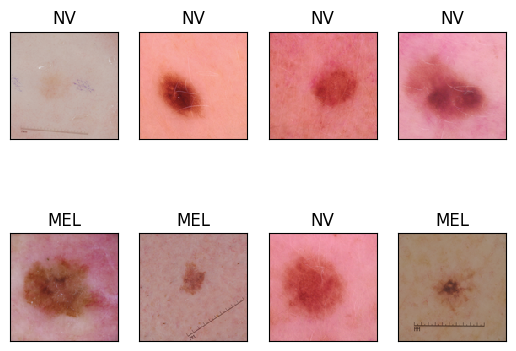

In [4]:
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

train_data = ImageFolder(train_dir, transform=torchvision.transforms.ToTensor())
val_data = ImageFolder(val_dir,transform =torchvision.transforms.ToTensor() ) 
test_dataset = ImageFolder(test_dir, transform=torchvision.transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=cpu_processors)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, num_workers=cpu_processors)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers = cpu_processors)

Xexamples, Yexamples = next(iter(train_loader))

for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

Printing sizes of the dataset.

In [5]:
# Check dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 6426
Validation set size: 1252
Test set size: 1366


1. In this implementation, we have used pre-trained VGG-16 model for image classification.
2. Modified the final layer to have 2 output classes as the problem is a binary classification problem.
3. Using CrossEntropyLoss() of nn module of torch library to calculate the loss function.
4. Using optim.adam of torch.optis to update the model's parameters from the above loss function. 

In [6]:
# Load pre-trained VGG16 model
model_vgg16 = models.vgg16(pretrained=True)

# Freeze all layers except the last one
for param in model_vgg16.parameters():
    param.requires_grad = False

# Modify the final layer to have 2 output classes
num_features = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_features, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg16.classifier[6].parameters(), lr=0.001)

c:\Users\Rupa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rupa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


`Baseline working model`

In [11]:
class InitCNN(nn.Module):
    def __init__(self,classifier_input = 2048, rate = 0.0):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size = 4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size = 5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, 512),
            nn.ReLU(),
            nn.Dropout(rate),
            nn.Linear(512,1)
        )
    
    def forward(self, X):
        featuresOut = self.features(X)
        flatten = torch.flatten(featuresOut, start_dim=1)
        out = self.classifier(flatten)
        return out.squeeze(1)
        

A function to train the model using the loaded data, criterion, optimizer, and setting epochs to 7 for considerable training.

As mentioned in the assignment description, used "with torch.no_grad()"

In [20]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=7):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            preds = torch.sigmoid(outputs) > 0.5
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Training Accuracy: {train_acc}')
        
        # Validation
        model.eval()
        model.to(device)
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                preds = torch.sigmoid(outputs) > 0.5
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        print(f'Validation Accuracy: {val_acc}')
    
    return model

Use the above function to train the `VGG-16` model.

In [8]:
# Train the model
model_vgg16 = train_model(model_vgg16, train_loader, val_loader, criterion, optimizer)


Epoch 1, Loss: 0.501411421775855, Training Accuracy: 0.7798008092125739
Validation Accuracy: 0.8099041533546326
Epoch 2, Loss: 0.5163060825906546, Training Accuracy: 0.7861811391223156
Validation Accuracy: 0.8186900958466453
Epoch 3, Loss: 0.5083037086540082, Training Accuracy: 0.7967631497043262
Validation Accuracy: 0.8162939297124601
Epoch 4, Loss: 0.5239046722307653, Training Accuracy: 0.7914721444133209
Validation Accuracy: 0.8178913738019169
Epoch 5, Loss: 0.5027580402064049, Training Accuracy: 0.7994086523498288
Validation Accuracy: 0.8242811501597445
Epoch 6, Loss: 0.529913099483194, Training Accuracy: 0.7978524743230626
Validation Accuracy: 0.8075079872204473
Epoch 7, Loss: 0.5455980145138462, Training Accuracy: 0.7973856209150327
Validation Accuracy: 0.8138977635782748


Training the CNN model form the above implemented class `InitCNN`

In [21]:
model_InitCNN = InitCNN()
criterion_CNN = nn.BCEWithLogitsLoss()
optimizer_CNN = optim.Adam(model_InitCNN.classifier.parameters(), lr=0.001)
model_InitCNN = train_model(model_InitCNN, train_loader, val_loader, criterion_CNN, optimizer_CNN)

Epoch 1, Loss: 0.5829571680309464, Training Accuracy: 0.6728913787737317
Validation Accuracy: 0.7404153354632588
Epoch 2, Loss: 0.4767713924842094, Training Accuracy: 0.7510115157173981
Validation Accuracy: 0.7364217252396166
Epoch 3, Loss: 0.4544710369308048, Training Accuracy: 0.7611266728913788
Validation Accuracy: 0.7603833865814696
Epoch 4, Loss: 0.43761657041251956, Training Accuracy: 0.7779333955804544
Validation Accuracy: 0.7675718849840255
Epoch 5, Loss: 0.4277626820446099, Training Accuracy: 0.7835356364768129
Validation Accuracy: 0.7539936102236422
Epoch 6, Loss: 0.41566780723853786, Training Accuracy: 0.7905384375972612
Validation Accuracy: 0.7899361022364217
Epoch 7, Loss: 0.41784805206776554, Training Accuracy: 0.7970743853096794
Validation Accuracy: 0.7723642172523961


Functions to evaluate the model using the `test dataset`.

Function to evalute the baseline CNN model on `test` dataset.

In [62]:
# Evaluation function
def evaluate_model_CNN(model, test_loader):
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = (outputs>0).squeeze().int()
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    test_acc = accuracy_score(test_labels, test_preds)
    print(f'Test Accuracy: {test_acc}')
    return test_acc

# Evaluate the model on the test set
test_accuracy_CNN = evaluate_model_CNN(model_InitCNN, test_loader)

Test Accuracy: 0.7847730600292826


Function to evaluate the pretrained VGG-16 model on the `test` dataset

In [41]:
# Evaluation function
def evaluate_model_VGG16(model, test_loader):
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    test_acc = accuracy_score(test_labels, test_preds)
    print(f'Test Accuracy: {test_acc}')
    return test_acc

test_accuracy_VGG16 = evaluate_model_VGG16(model_vgg16, test_loader)

Test Accuracy: 0.8243045387994143


Applying `Normalization` to our `baseline CNN` model

In [49]:
class CNN_normalized(nn.Module):
    def __init__(self, classifier_size = 2048, norm = 'batch', groupSize = 32, dropRate = 0.0):
        super().__init__()

        normLayer = {
            'batch': nn.BatchNorm2d,
            'layer': lambda features: nn.LayerNorm(features),
            'group': lambda features: nn.GroupNorm(groupSize, features)
        }[norm]

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            normLayer([32, 224, 224] if norm=='layer' else 32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            normLayer([64, 112, 112] if norm=='layer' else 64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            normLayer([128, 56, 56] if norm=='layer' else 128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=4, padding=1),
            normLayer([256, 27, 27] if norm=='layer' else 256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=5, padding=1),
            normLayer([512, 11, 11] if norm=='layer' else 512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(classifier_size, 512),
            nn.ReLU(),
            nn.Dropout(dropRate),
            nn.Linear(512,1)
        )
    
    def forward(self, X):
        features = self.features(X)
        flattened = torch.flatten(features, start_dim=1)
        out = self.classifier(flattened)
        return out.squeeze(1)

Training the `Normalized CNN` model using suitable `Criterion` and `Optimizer`

In [51]:
model_NormalizedCNN = CNN_normalized(classifier_size=2048, norm='batch', dropRate=0.1)

criterion_NormalizedCNN = nn.BCEWithLogitsLoss()
optimizer_NormalizedCNN = optim.Adam(model_NormalizedCNN.classifier.parameters(), lr=0.001)
NormalizedCNN = train_model(model_NormalizedCNN, train_loader, val_loader, criterion_NormalizedCNN, optimizer_NormalizedCNN)

Epoch 1, Loss: 0.4864083416759968, Training Accuracy: 0.7544351073762838
Validation Accuracy: 0.7907348242811502
Epoch 2, Loss: 0.4240341796840898, Training Accuracy: 0.789760348583878
Validation Accuracy: 0.7987220447284346
Epoch 3, Loss: 0.40185169214892447, Training Accuracy: 0.8020541549953315
Validation Accuracy: 0.8234824281150159
Epoch 4, Loss: 0.3760420511481329, Training Accuracy: 0.8183940242763772
Validation Accuracy: 0.8059105431309904
Epoch 5, Loss: 0.371946651534877, Training Accuracy: 0.817615935262994
Validation Accuracy: 0.8170926517571885
Epoch 6, Loss: 0.3621267637363009, Training Accuracy: 0.8294428882664177
Validation Accuracy: 0.8258785942492013
Epoch 7, Loss: 0.35803995723488613, Training Accuracy: 0.8260192966075319
Validation Accuracy: 0.8170926517571885


`Evaluation` function for evaluating the `Normalized CNN` model on test dataset

In [52]:
# Evaluation function
def evaluate_model_NormalizedCNN(model, test_loader):
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = (outputs>0).squeeze().int()
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    test_acc = accuracy_score(test_labels, test_preds)
    print(f'Test Accuracy: {test_acc}')
    return test_acc

# Evaluate the model on the test set
test_accuracy_NormalizedCNN = evaluate_model_NormalizedCNN(model_NormalizedCNN, test_loader)

Test Accuracy: 0.8301610541727672


Applying `Residual Connections` on the normalized CNN

In [53]:
class ResidualBlock(nn.Module):
    def __init__(self, InChannels, OutChannels, NormLayer, stride=1, GroupSize=32):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(InChannels, OutChannels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.norm1 = NormLayer(OutChannels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(OutChannels, OutChannels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.norm2 = NormLayer(OutChannels)

        self.shortcut = nn.Sequential()
        if stride != 1 or InChannels != OutChannels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(InChannels, OutChannels, kernel_size=1, stride=stride, bias=False),
                NormLayer(OutChannels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.norm2(out)

        identity = self.shortcut(identity)

        out += identity
        out = self.relu(out)

        return out


class Residual_NormalizedCNN(nn.Module):
    def __init__(self, size_classifier=2048, normType='batch', GroupSize=32, dropoutRate=0.0):
        super().__init__()
        
        NormLayer = {
            'batch': nn.BatchNorm2d,
            'layer': lambda features: nn.LayerNorm(features),
            'group': lambda features: nn.GroupNorm(GroupSize, features)
        }[normType]

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            NormLayer(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            ResidualBlock(32, 64, NormLayer, GroupSize=GroupSize),
            nn.MaxPool2d(2),
            
            ResidualBlock(64, 128, NormLayer, GroupSize=GroupSize),
            nn.MaxPool2d(2),
            
            ResidualBlock(128, 256, NormLayer, GroupSize=GroupSize),
            nn.MaxPool2d(2),
            
            ResidualBlock(256, 512, NormLayer, GroupSize=GroupSize),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(size_classifier, 512),
            nn.ReLU(),
            nn.Dropout(dropoutRate),
            nn.Linear(512, 1),
        )

    def forward(self, X):
        features_out = self.features(X)
        flatten = torch.flatten(features_out, start_dim=1)
        out = self.classifier(flatten)
        return out.squeeze(1)

`Training` the model using the `train_model` function using the suitable `criterion` and `optimizer`

In [58]:
model_residualNormalizedCNN = Residual_NormalizedCNN(size_classifier=8192, normType='group', dropoutRate=0.1)

criterion_ResNormCNN = nn.BCEWithLogitsLoss()
optimizer_ResNormCNN = optim.Adam(model_residualNormalizedCNN.classifier.parameters(), lr=0.001)
model_residualNormalizedCNN = train_model(model_residualNormalizedCNN, train_loader, val_loader, criterion_ResNormCNN, optimizer_ResNormCNN)

Epoch 1, Loss: 0.5308681862215646, Training Accuracy: 0.747743541861189
Validation Accuracy: 0.7723642172523961
Epoch 2, Loss: 0.4250933755402319, Training Accuracy: 0.7911609088079676
Validation Accuracy: 0.7196485623003195
Epoch 3, Loss: 0.3954474960421374, Training Accuracy: 0.8046996576408341
Validation Accuracy: 0.8027156549520766
Epoch 4, Loss: 0.3777706196059042, Training Accuracy: 0.8183940242763772
Validation Accuracy: 0.8162939297124601
Epoch 5, Loss: 0.3693472440702035, Training Accuracy: 0.8216619981325863
Validation Accuracy: 0.8178913738019169
Epoch 6, Loss: 0.3520156093687746, Training Accuracy: 0.8339558045440398
Validation Accuracy: 0.829073482428115
Epoch 7, Loss: 0.3442143622799707, Training Accuracy: 0.837223778400249
Validation Accuracy: 0.8186900958466453


`Evaluating` the performance of the `Residual connected Normalized CNN`

In [59]:
# Evaluation function
def evaluate_model_ResNormalizedCNN(model, test_loader):
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = (outputs>0).squeeze().int()
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    test_acc = accuracy_score(test_labels, test_preds)
    print(f'Test Accuracy: {test_acc}')
    return test_acc

# Evaluate the model on the test set
test_accuracy_ResNormalizedCNN = evaluate_model_ResNormalizedCNN(model_residualNormalizedCNN, test_loader)

Test Accuracy: 0.8308931185944363


`Data Augmentation`

In [61]:
resize = 256
CropSize = 224

train_transforms = transforms.Compose([
    transforms.Resize(resize),
    transforms.CenterCrop(resize),
    transforms.RandomResizedCrop(CropSize, scale=(0.8, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(resize),
    transforms.CenterCrop(resize),
    transforms.Resize(CropSize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainFolder = ImageFolder('train', transform=train_transforms)
train_loader_aug = DataLoader(trainFolder, batch_size = 8, shuffle=True)

valFolder = ImageFolder('val', transform=val_transforms)
val_loader = DataLoader(valFolder, batch_size=8, shuffle=False, num_workers=4,pin_memory=True)